* Image denoising is to remove noise from a noisy image, so as to restore the true image
* In this notebook FER2013 dataset is used which contains approx 35 thousand images of 7 different emotions
* Image is grayscale of size 48*48

# Importing libraries

In [ ]:
from keras.datasets import fashion_mnist, mnist
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

# Any results you write to the current directory are saved as output.
from IPython.display import display, Image

## Extract data from CSV

In [ ]:
# get the data
filname = '../input/facial-expression/fer2013/fer2013.csv'

#different labels of images(not useful known about for current problem)
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

#different features names
names=['emotion','pixels','usage']

#Reading data in dataframe
df=pd.read_csv('../input/facial-expression/fer2013/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

## Adding labels and images(pixel values) in respective array

In [ ]:
#reading data and labels from dataset and appending in list

def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X), np.array(Y)
    return X, Y

In [ ]:
#extracting data from dataset
X, Y = getData(filname)
num_class = len(set(Y))
#print(num_class)

## Reshaping images

In [ ]:
# keras with tensorflow backend
N, D = X.shape

#reshaping the dataset
X = X.reshape(N, 48, 48, 1)

# Extracting Data and splitting train and test 

# Test_size change garera herna milyo

In [ ]:
#splitting data in train, test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
x_train.shape

# Data Preprocessing

# noise factor: 0.05

1. The parameter is the mean or expectation of the distribution (and also its median and mode), while the parameter is its standard deviation. The variance of the distribution is. . A random variable with a Gaussian distribution is said to be normally distributed, and is called a normal deviate.
1. A normal distribution with a mean of 0 and a standard deviation of 1 is called a standard normal distribution.
1. Gaussian distribution (also known as normal distribution) is a bell-shaped curve, and it is assumed that during any measurement values will follow a normal distribution with an equal number of measurements above and below the mean value.

# To learn about poission distribution
https://numpy.org/doc/stable/reference/random/generated/numpy.random.poisson.html

1. A Poisson distribution is discrete while a normal distribution is continuous, and a Poisson random variable is always >= 0. 

1. A Poisson distribution with a high enough mean approximates a normal distribution, even though technically, it is not. One difference is that in the Poisson distribution the variance = the mean. In a normal distribution, these are two separate parameters.

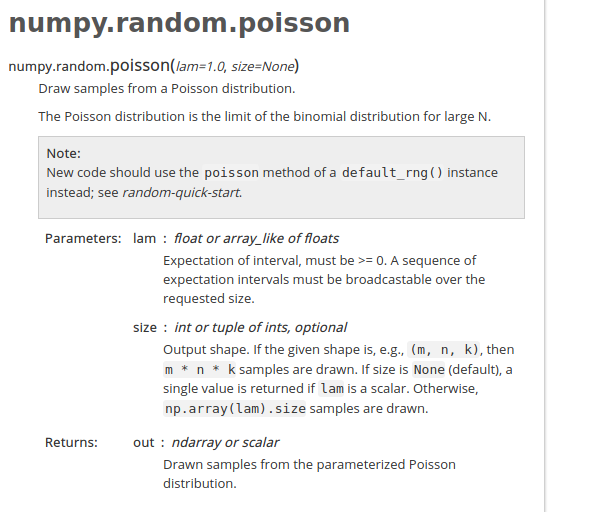

In [ ]:
#NOrmalizing the images
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#reshaping the images
x_train = np.reshape(x_train, (len(x_train), 48, 48, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 48, 48, 1))  # adapt this if using `channels_first` image data format


#adding noise in data
noise_factor = 0.1

from skimage.util import random_noise


x_train_noisy = x_train + noise_factor * np.random.poisson(lam=(0,1), size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.poisson(lam=(0,1), size=x_test.shape) 

#clipping put data near to 0--->0 aand data near to 1-->1(eg=0.3-->0 or 0.7-->1)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)



# Taking 100 images seperate for final testing

In [ ]:
x_test_final_noisy = x_test_noisy[-100:]
x_test_noisy = x_test_noisy[:-100]

x_test_final_original = x_test[-100:]
x_test = x_test[:-100]

# Visualization of 10 Data

In [ ]:
n = 10

In [ ]:
plt.figure(figsize=(48, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_train_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# One of the way we can achieve our goal of removing noise is AutoEncoder

**Copied from Keras Blog(https://blog.keras.io/building-autoencoders-in-keras.html):
**
* What are autoencoders good for?
* Today two interesting practical applications of autoencoders are data denoising (which we feature later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

**Refer to Keras Blog for better idea : https://blog.keras.io/building-autoencoders-in-keras.html**

## AutoEncoder Architecture

In [ ]:
display(Image(filename="/kaggle/input/images-architecture/images_architecture/autoencoder.png"))

# Construction of Model

In [ ]:
input_img = Input(shape=(48, 48, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)


# To learn more see: 

1. https://keras.io/api/optimizers/adam/
1. https://keras.io/api/optimizers/

# Why bias 0.9

https://www.youtube.com/watch?v=k8fTYJPd3_I

In [ ]:
opt = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

In [ ]:
#learning rate, beta1, beta2
autoencoder.compile(optimizer=opt, loss='MSE')

# AutoEncoder Summary

In [ ]:
autoencoder.summary()

# Training Model

The **ModelCheckpoint** callback class allows you to define where to checkpoint the model weights, how the file should named and under what circumstances to make a checkpoint of the model. The API allows you to specify which metric to monitor, such as loss or accuracy on the training or validation dataset.

In [ ]:
from keras import callbacks
file_path = "weights_best_.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=35,
                batch_size=128,
                shuffle=True,
                callbacks = callbacks_list,
                validation_data=(x_test_noisy, x_test))

## Making Prediction

In [ ]:
predict = autoencoder.predict(x_test_final_noisy)

# Visualizing the prediction

## Original Test images

In [ ]:
n=5

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_final_original[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Noised Test images

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_final_noisy[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Generated Test images

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(48, 48))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# AutoEncoder: Train Loss VS validation loss

In [ ]:
autoencoder.history.history

In [ ]:
epochs = range(len(autoencoder.history.history['loss']))

plt.plot(epochs,autoencoder.history.history['loss'],'r-o', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()



In [ ]:
epochs = range(len(autoencoder.history.history['loss']))

plt.plot(epochs,autoencoder.history.history['loss'],'r-o', label='Training Loss')
plt.plot(epochs,autoencoder.history.history['val_loss'],'b-o', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()



In [ ]:
from skimage.measure import compare_ssim, compare_psnr, compare_mse
from skimage import data, img_as_float

# MSE between Images

* Compare MSE between two images

In [ ]:
# Fourth Image
compare_mse(x_test_final_original[3], predict[3])

In [ ]:
# Fifth Image
compare_mse(x_test_final_original[4], predict[4])

In [ ]:
# Third Image
compare_mse(x_test_final_original[2], predict[2])

# For Whole final_test Dataset

In [ ]:
# whole dataset
compare_mse(x_test_final_original, predict)

# Structural Similarity Index

* When comparing images, the mean squared error (MSE)--while simple to implement--is not highly indicative of perceived similarity. Structural similarity aims to address this shortcoming by taking texture into account



In [ ]:
#fouth Image
compare_ssim(x_test_final_original[3], predict[3], multichannel=True)

In [ ]:
#fifth Image
compare_ssim(x_test_final_original[4], predict[4], multichannel=True)

In [ ]:
#Third Image
compare_ssim(x_test_final_original[2], predict[2], multichannel=True)

In [ ]:
# whole test dataset
compare_ssim(x_test_final_original, predict, multichannel=True)

In [ ]:
autoencoder.save('model_keras.h5')